# Disease Course Sequencing with the EBM
## Event-Based Model of disease progression
Author: Neil Oxtoby, UCL

Originally a tutorial on the [DPM website](https://disease-progression-modelling.github.io)

## Objectives:

This notebook walks you through how to fit an event-based model of disease progression using publicly available software and simulated data.

The steps involved:
- Load input data
  - e.g., a CSV table of disease features (biomarkers) in a cohort including patients and healthy controls
- Prepare the input data: select a subset of features; perform some basic statistical checks; etc.
- Fit the model
- Perform cross-validation

We add additional steps as didactic exemplars of good practice in data-driven disease progression modelling. 

## The set-up

This notebook is currently designed to run in a specially prepared conda environment, using the [KDE EBM](https://github.com/ucl-pond/kde_ebm) package (see [installation instructions](https://github.com/ucl-pond/kde_ebm/blob/master/INSTALL.md) on GitHub).

In the future we may support running this in the cloud.

In [48]:
# Import some packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # default fontsize

## Simulate some data

Text(0, 0.5, 'sigmoid(t)')

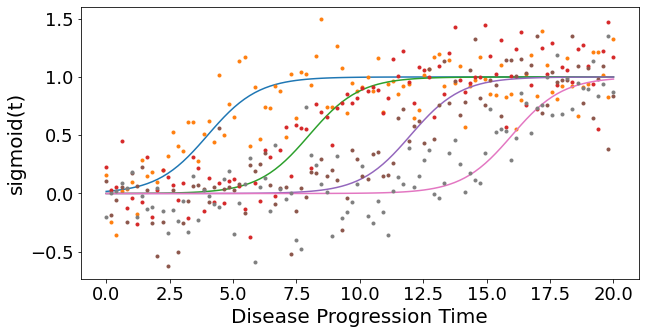

In [49]:
N = 4   # number of events/features
J = 100 # number of patients

noise_scale = 0.2

dp = np.linspace(0, 20, J)
def sigmoid(t,a=1,b=-10):
    return 1/(1 + np.exp(-a*(t-b)))

gradients = np.array([1,1,1,1])
onsets    = np.array([4,8,12,16])

X = np.empty(shape=(J,N))
fig,ax = plt.subplots(figsize=(10,5))
for a,b,k in zip(gradients,onsets,range(len(gradients))):
    # print('a = %i, b = %i' % (a,b))
    x = sigmoid(t=dp,a=a,b=b)
    #print(x)
    ax.plot(dp, x)
    y = x + np.random.normal(0, noise_scale, x.size)
    X[:,k] = y
    ax.plot(dp, y,'.')

ax.set_xlabel("Disease Progression Time",fontsize=20) 
ax.set_ylabel("sigmoid(t)",fontsize=20)

In [50]:
#* Sample some controls
X_controls = np.empty(shape=X.shape)
for k in range(len(gradients)):
    X_controls[:,k] = np.random.normal(0, noise_scale, (X_controls.shape[0],))

## Didactic step: Look at the data

1. Visual: look at the histograms of patients and controls
2. Statistical tests: use null hypothesis statistical tests of "differences" to select features
  - Loosely speaking, a significant difference suggests presence of "disease signal" (patient measurements are "different" to controls measurements) in a biomarker

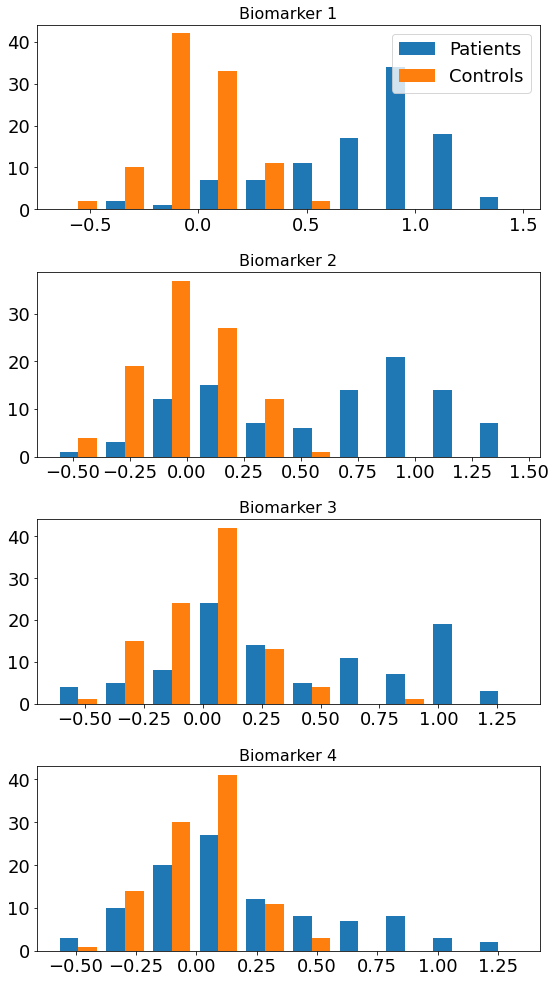

In [51]:
#* 1. Histograms
fig,ax = plt.subplots(N,1,figsize=(8,14))
for k in range(N):
    ax[k].hist([ X[:,k],X_controls[:,k]],label=['Patients','Controls'])
    ax[k].set_title('Biomarker %i' % (k+1),fontsize=16)
ax[0].legend()
fig.tight_layout()

## Basic statistical tests

- Effect size: (difference in medians) / ("width" of controls distribution)

- Mann-Whitney U test (quoting Wikipedia):<br/>
> a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

In [52]:
#* 2. Basic statistics
# I use a nonparametric test because it works regardless of the data distributions 
# (some tests assume some level of Gaussianity)
from scipy import stats
print('Mann Whitney U test')

for k in range(N):
    x_c = X_controls[:,k]
    x_p = X[:,k]
    effect_size = np.absolute(np.median(x_p)-np.median(x_c))/stats.median_abs_deviation(x_c)
    u,p = stats.mannwhitneyu(x_c,x_p)
    print('Biomarker %i\n - effect size = %.3g\n - u = %i, p = %.2g' % (k+1,effect_size,u,p))

Mann Whitney U test
Biomarker 1
 - effect size = 6.67
 - u = 484, p = 2.6e-28
Biomarker 2
 - effect size = 5.19
 - u = 1483, p = 8.5e-18
Biomarker 3
 - effect size = 2.47
 - u = 2341, p = 8.3e-11
Biomarker 4
 - effect size = 0.616
 - u = 3588, p = 0.00056


## Prepare data for fitting

Data matrix `X` has `M` individuals (patients, controls, prodromal/at-risk individuals) and `N` biomarkers/events

In [53]:
#* Setup data for fitting
y          = np.ones(shape=(X.shape[0],1))
y_controls = np.zeros(shape=(X_controls.shape[0],1))

X_patients_controls = np.concatenate((X,X_controls),axis=0)
y_patients_controls = np.concatenate((y,y_controls),axis=0)

X = X_patients_controls
y = y_patients_controls.flatten().astype(int)

## Missing data (for a second run below)

Generated approximately 10% missing data in 1 of 4 biomarkers


/var/folders/dl/gjzs07_s27v2lff3_khf2mlc0000gn/T/ipykernel_52301/2587799672.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


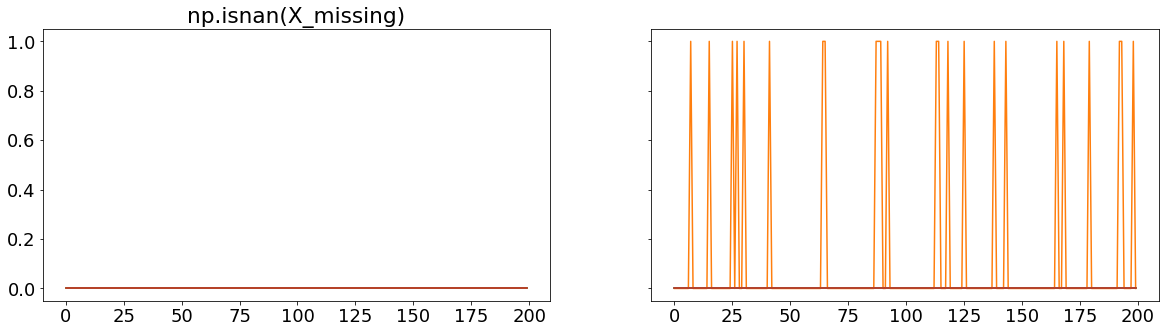

In [54]:
#* Missing data
biomarkers_with_missing_data = np.random.random(X.shape[1]) > 0.4
missingness_per_biomarker = 0.1

print(f"Generated approximately {int(100*missingness_per_biomarker)}% missing data in {np.sum(biomarkers_with_missing_data)} of {X.shape[1]} biomarkers")

missing_data_mask = np.random.random(X.shape) < missingness_per_biomarker
np.putmask(missing_data_mask,np.tile(~biomarkers_with_missing_data,(X.shape[0],1)),False)

X_missing = X.copy()
np.putmask(X_missing,missing_data_mask,np.nan)

fig,ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].plot(np.isnan(X))
ax[0].set_title("np.isnan(X)")
ax[1].plot(np.isnan(X_missing))
ax[0].set_title("np.isnan(X_missing)")
fig.show()

## Fit mixture models

This step maps biomarker values `x` (columns of data matrix `X`) to `p(event)`, allowing for patients to be at different stages of cumulative abnormality.

Typical group-level analyses simply compare measurements from patients with controls, e.g., looking for statistical "differences" in the mean values. The mixture model allows for patients to have both abnormal observations that deviate from controls (these are early disease events), and normal observations (these will be later disease events)


In [55]:
from kde_ebm.mixture_model import fit_all_kde_models, fit_all_gmm_models, get_prob_mat

from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram

from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures


In [56]:
#* Label the biomarkers/events
e = ['Early','Early-ish','Late-ish','Late']
e_labels = e
#* Direction of progression (1 = biomarker increases in patients; -1 = biomarker decreases in patients)
#  This is a feature of the KDE EBM software.
e_disease_direction_dict = {'Early':1,'Early-ish':1,'Late-ish':1,'Late':1}
e_disease_direction = [e_disease_direction_dict[f] for f in e]

In [57]:
kde_mixtures = fit_all_kde_models(
    X, y,
    implement_fixed_controls = True,
    patholog_dirn_array      = e_disease_direction
)

(<Figure size 864x864 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Early'}>,
         <AxesSubplot:title={'center':'Early-ish'}>],
        [<AxesSubplot:title={'center':'Late-ish'}>,
         <AxesSubplot:title={'center':'Late'}>]], dtype=object))

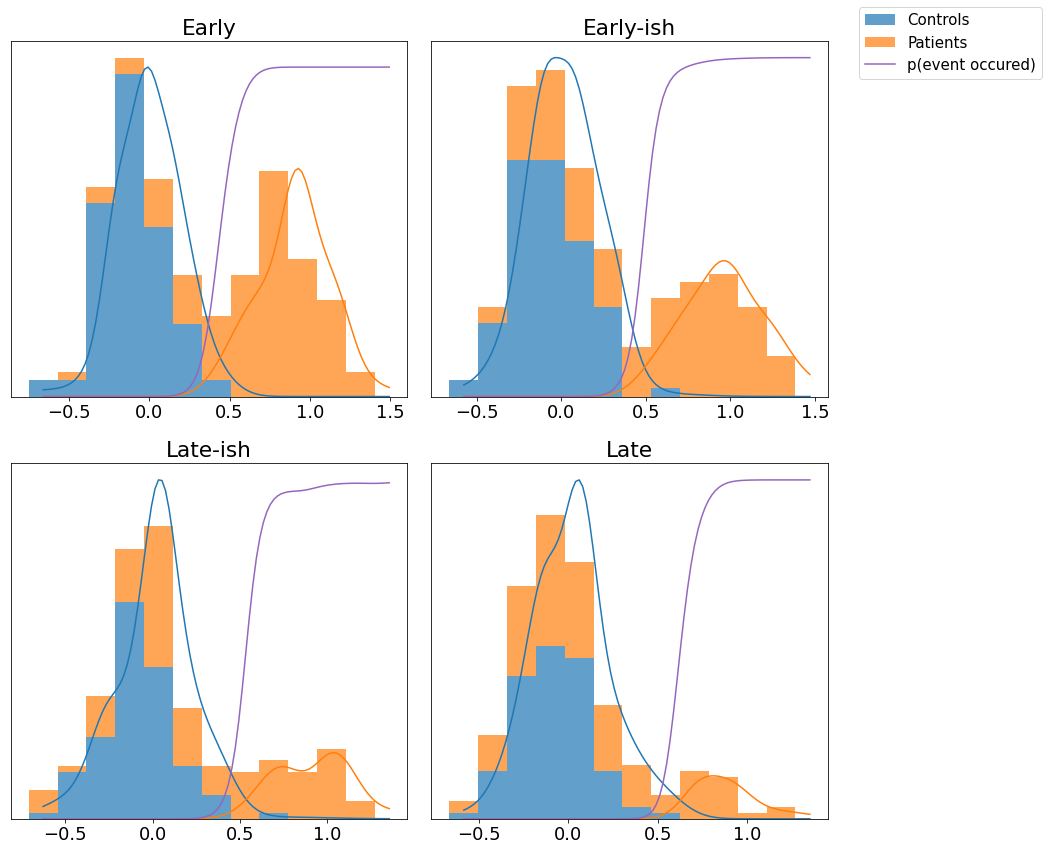

In [58]:
#* View the mixture models
mixture_model_grid(
    X,y,
    kde_mixtures,
    score_names=e,
    class_names=['Controls','Patients']
)

(<Figure size 864x864 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Early'}>,
         <AxesSubplot:title={'center':'Early-ish'}>],
        [<AxesSubplot:title={'center':'Late-ish'}>,
         <AxesSubplot:title={'center':'Late'}>]], dtype=object))

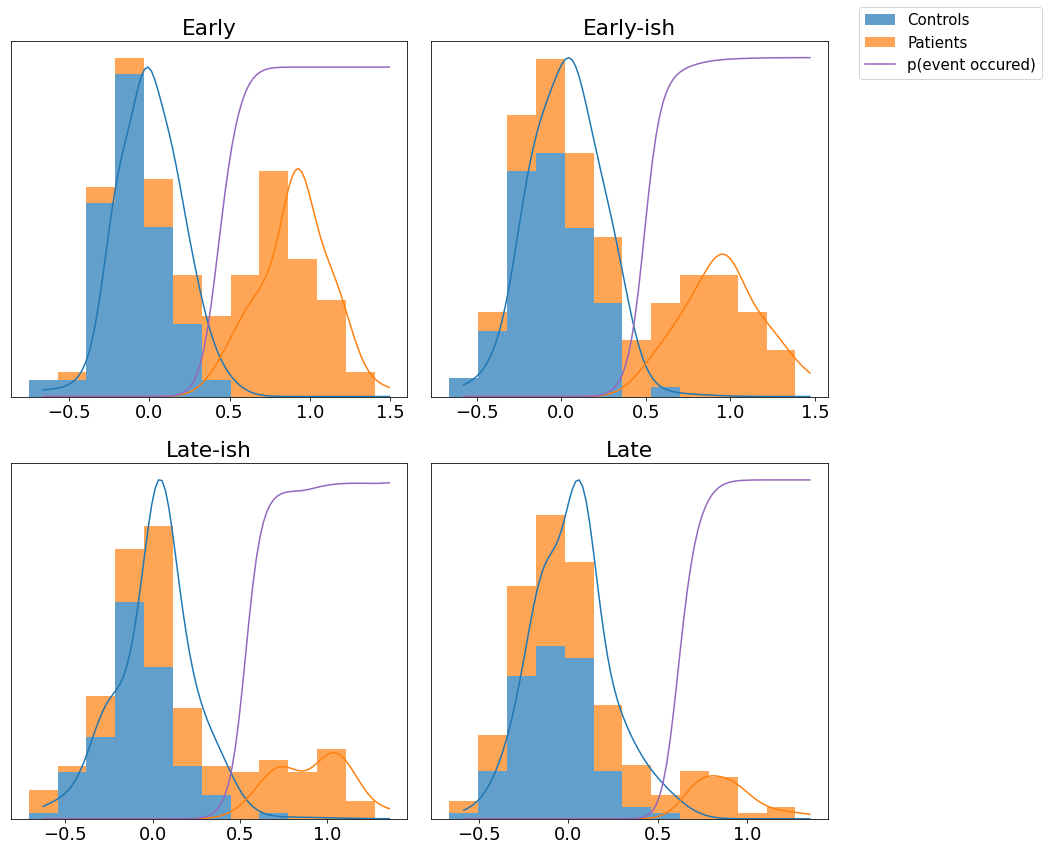

In [59]:
kde_mixtures_missing = fit_all_kde_models(
    X_missing, y,
    implement_fixed_controls = True,
    patholog_dirn_array      = e_disease_direction
)
#* View the mixture models
mixture_model_grid(
    X_missing,y,
    kde_mixtures_missing,
    score_names=e,
    class_names=['Controls','Patients']
)

## Sequencing using MCMC: Markov Chain Monte Carlo

This is a standard method for approximating a model posterior when exact inference is intractable.

Here we are performing maximum likelihood inference. The EBM posterior is intractable in general because evaluating the likelihood function requires calculating the likelihood of all `N!` possible sequences for `N` biomarkers.

This quickly explodes for `N > 6`, so we generate _random samples from the posterior_ (the full set of possible sequences) using MCMC, and keep only those sequences that increase the likelihood (ideally towards the maximum).

In general, the posterior won't be a convex function, i.e., one having a single easy-to-find maximum.

In practice, the posterior could consist of multiple maxima at different locations in parameter space. To avoid getting "stuck" in a local maximum, we follow good machine learning practice when searching parameter space to sample from the posterior: multiple random initialisations of the sampling, greedy initialisation, and MCMC sampling.

Details of the bespoke MCMC algorithm used here are in the original EBM paper: [Fonteijn _et al._, NeuroImage (2012)](https://doi.org/10.1016/j.neuroimage.2012.01.062).



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10763.46it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10540.66it/s]


ML order   : Early, Early-ish, Late-ish, Late


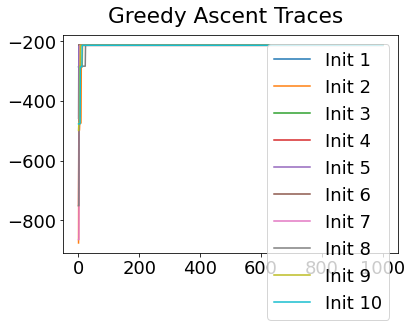

In [60]:
#* MCMC sequencing
mcmc_samples = mcmc(X, kde_mixtures)
#* Maximum Likelihood sequence over all samples
seq_ml = mcmc_samples[0].ordering
# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([e_labels[k] for k in seq_ml]))
      

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10817.70it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10586.85it/s]


ML order   : Early, Early-ish, Late-ish, Late


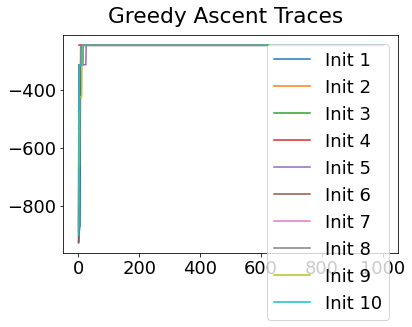

In [61]:
#* MCMC sequencing
mcmc_samples_missing = mcmc(X_missing, kde_mixtures_missing)
#* Maximum Likelihood sequence over all samples
seq_ml_missing = mcmc_samples_missing[0].ordering
# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([e_labels[k] for k in seq_ml_missing]))
      

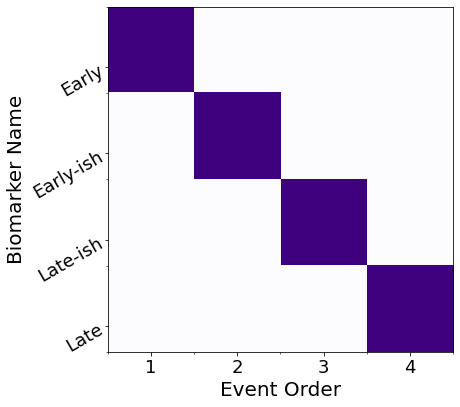

In [62]:
# View the ML posterior
f,a = mcmc_uncert_mat(mcmc_samples, ml_order=None, score_names=e_labels)

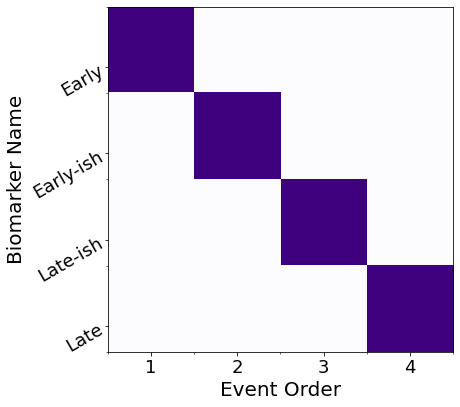

In [63]:
f,a = mcmc_uncert_mat(mcmc_samples_missing, ml_order=None, score_names=e_labels)

In [64]:
# Save in a dict()
ebm_results = {"mixtures": kde_mixtures, "mcmc_samples": mcmc_samples, "sequence_ml": seq_ml}

### Example of how to tweak the output positional variance diagram

I define some convenience functions, then use them to plot

In [65]:
import itertools
def extract_pvd(ml_order,samples):
    if type(ml_order) is list:
        #* List of PVDs from cross-validation/bootstrapping
        n_ = len(ml_order[0])
        pvd = np.zeros((n_,n_))
        #all_orders = np.array(ml_order)
        if type(samples[0]) is list:
            #* 10-fold CV returns MCMC samples for each fold separately in a list - concatenate them here
            all_samples = list(itertools.chain.from_iterable(samples))
        else:
            #* Bootstrapping returns MCMC samples pre-concatenated
            all_samples = samples
        all_orders = np.array([x.ordering for x in all_samples])
        for i in range(n_):
            pvd[i, :] = np.sum(all_orders == ml_order[0][i], axis=0)
        #pvd_cv, cv_rank = reorder_PVD_average_ranking(PVD=pvd)
        pvd, rank = reorder_PVD(pvd)
        seq = [ml_order[0][i] for i in rank]
    else:
        #* Single PVD (ML results)
        n_ = len(ml_order)
        pvd = np.zeros((n_,n_))
        samples_ = np.array([x.ordering for x in samples])
        seq = ml_order
        for i in range(n_):
            pvd[i, :] = np.sum(samples_ == seq[i], axis=0)
    return pvd, seq

def reorder_PVD(PVD,mean_bool=False,edf_threshold=0.5):
    """
    Reorders a PVD by scoring the frequencies in each row, then ranking in increasing order.

    Score: integral of complementary empirical distribution (1-EDF) up to a threshold.
    Rationale: the sooner the EDF gets to the threshold, the earlier it should be in the ranking.

    """

    if mean_bool:
        n_ = PVD.shape[0]
        ranking = np.linspace(1,n_,n_) # weights
        weights = PVD
        mean_rank = []
        for i in range(n_):
            mean_rank.append( sum( weights[i,:] * ranking ) / sum(weights[i,:]) )
        new_order = np.argsort(mean_rank)
    else:
        #* Find where the empirical distribution first exceeds the threshold
        edf = np.cumsum(PVD,axis=1)
        edf = edf / np.tile(np.max(edf,axis=1).reshape(-1,1),(1,edf.shape[1]))
        edf_above_threshold = []
        for k in range(edf.shape[0]):
            edf_above_threshold.append(np.where(edf[k,:]>=edf_threshold)[0][0])
        #* Ties implicitly split by original ordering in the PVD (likely the ML ordering)
        edf_rank = np.argsort(edf_above_threshold)
        new_order = edf_rank

    PVD_new = PVD[new_order,:]
    # PVD_new = np.zeros((n_,n_))
    # for i in range(n_):
    #     PVD_new[i, :] = PVD[new_order[i],:]

    return PVD_new, new_order

# Frontiers default is pdf with 300dpi
# And run it all through imagemagick after to convert
def save_plot(fig, fname, fig_format="png", dpi=150, **kwargs):
    fig.savefig(
        f"{fname}.{fig_format}",
        dpi=300,
        bbox_inches="tight",
        **kwargs
    )

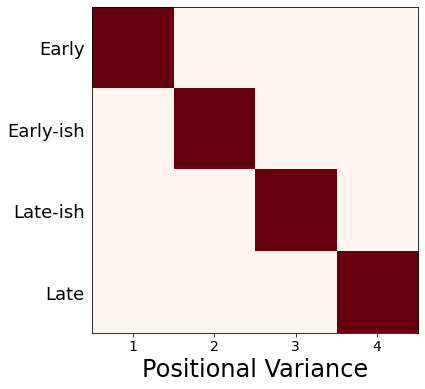

In [66]:
# Get labels
nom = 'tute'
#* Plot EBM (PVD)
pvd_ml, seq_ml = extract_pvd(ml_order=seq_ml,samples=mcmc_samples)
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = e_labels
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_ml]
ax.imshow(pvd_ml_[:][seq_ml], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Positional Variance', fontsize=24)
ax.grid(False)

save_plot(fig, nom+"-PVD_ML")

## Patient staging utility

Concept: align individuals to the model

Method (see [Young et al, Brain 2014](https://doi.org/10.1093/brain/awu176)): compare data from each individual (patients/controls/at-risk) with the model and calculate a `p(event)` vector, then assign the most likely stage according to the accumulation of disease events

In [67]:
#* Define the EBM staging function
def ebm_staging(x,mixtures,samples):
    """
    Given a trained EBM (mixture_models,mcmc_samples), and correctly-formatted data, stage the data
    NOTE: To use CV-EBMs, you'll need to call this for each fold, then combine.
    Author: Neil P Oxtoby, UCL, September 2018
    """
    if type(mixtures[0]) is list:
        #* List of mixture models from cross-validation / bootstrapping
        n_cv = len(mixtures)
        prob_mat = []
        stages = []
        stage_likelihoods = []
        stages_expected = []
        for k in range(n_cv):
            #* Stage the data
            prob_mat.append(get_prob_mat(x, mixtures[k]))
            stages_k, stage_likelihoods_k = samples[k][0].stage_data(prob_mat[k])
            stages.append(stages_k)
            stage_likelihoods.append(stage_likelihoods_k)
            #* Average (expectation value) stage
            stages_expected_k = np.ndarray(shape=stages_k.shape)
            for kk in range(stages_expected_k.shape[0]):
                stages_expected_k[kk] = np.sum(stage_likelihoods_k[kk,:]*np.arange(1,stage_likelihoods_k.shape[1]+1,1))/np.sum(stage_likelihoods_k[kk,:]) - 1
            stages_expected.append(stages_expected_k)
    else:
        #* Stage the data
        prob_mat = get_prob_mat(x, mixtures)
        if type(samples[0]) is list:
            n_bs = len(samples)
            stages = []
            stage_likelihoods = []
            stages_expected = []
            for k in range(n_bs):
                #* Stage the data
                stages_k, stage_likelihoods_k = samples[k][0].stage_data(prob_mat)
                stages.append(stages_k)
                stage_likelihoods.append(stage_likelihoods_k)
                #* Average (expectation value) stage
                stages_expected_k = np.ndarray(shape=stages_k.shape)
                for kk in range(stages_expected_k.shape[0]):
                    stages_expected_k[kk] = np.sum(stage_likelihoods_k[kk,:]*np.arange(1,stage_likelihoods_k.shape[1]+1,1))/np.sum(stage_likelihoods_k[kk,:]) - 1
                stages_expected.append(stages_expected_k)
        else:
            stages, stage_likelihoods = samples[0].stage_data(prob_mat)
            #* Average (expectation value) stage
            stages_expected = np.ndarray(shape=stages.shape)
            for k in range(stages_expected.shape[0]):
                stages_expected[k] = np.sum(stage_likelihoods[k,:]*np.arange(1,stage_likelihoods.shape[1]+1,1))/np.sum(stage_likelihoods[k,:]) - 1
    # #* Average (expectation value) stage
    # stages_expected_n = np.sum(stage_likelihoods,axis=1)
    # stages_expected_ = np.average(stage_likelihoods_long_ml,axis=1,weights=np.arange(1,stage_likelihoods_long_ml.shape[1]+1,1))
    # stages_expected_ = stages_expected_/stages_expected_n
    
    return prob_mat, stages, stage_likelihoods, stages_expected


In [68]:
#* Staging
#* Maximum-likelihood model stage: could include longitudinal data, including followups not used to train the EBM
prob_mat_ml, stages_long_ml, stage_likelihoods_long_ml, stages_long_ml_expected = ebm_staging(
    x=X,
    mixtures=kde_mixtures,
    samples=mcmc_samples
)
stages_long = stages_long_ml

### Plot a staging histogram

Number of individuals in each EBM stage

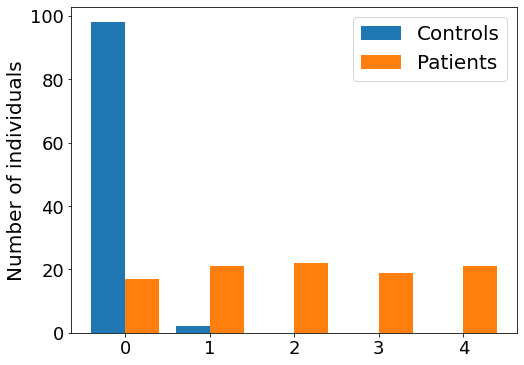

In [69]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist([ stages_long[y==0], stages_long[y==1]],bins=np.arange(-0.5,N+1.5,1))
# #* Seaborn version: requires creating a Pandas DataFrame and adding data/etc.
# ax = sns.histplot(
#     data = df_staging,
#     x    = stage_column,
#     hue  = "Status",
#     ax   = ax
#     discrete  = True,
#     multiple  = "dodge",
#     log_scale = (False, True),
#     palette   = status_palette,
# )
ax.set_ylabel('Number of individuals',fontsize=20)
ax.legend(['Controls','Patients'],fontsize=20)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

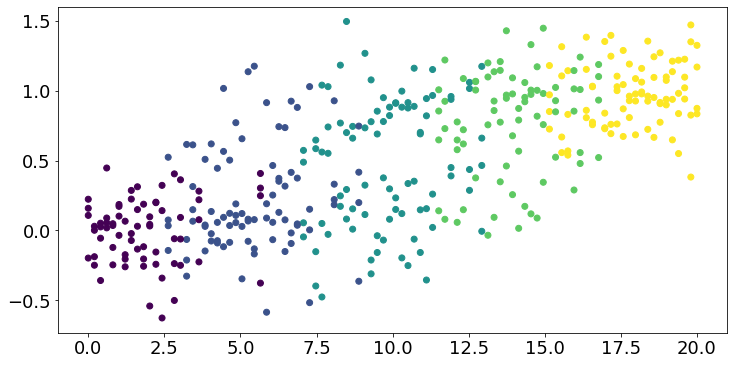

In [70]:
#* Plot the original data, coloured by stage
fig,ax = plt.subplots(figsize=(12,6))

for k in range(N):
    plt.scatter(dp,X[y==1,k],c=stages_long[y==1],cmap='viridis',label='')
plt.plot
# ax.legend(['Stage %i' % k for k in range(N)],loc='center right',bbox_to_anchor=[1.5,0.5])


In [71]:
#* Missing data


<hr/>
<hr/>

## Bonus: Cross-validation

Generalizability/robustness of a model can be quantified by **testing** the model on independent data, i.e., data not included when training the model.

Cross-validation does this by splitting the available data into train/test sets.

### k-fold cross-validation

Splitting a dataset into `k` "folds" enables calculation of model performance statistics (e.g., mean, standard deviation) over `k` test sets, using the other `k-1` folds to train the model each time.

It is common to use `k=10`, which amounts to using 90% of your data to train and 10% to test.

This process can be repeated multiple times using different random partitions (splits) into folds.


![image_kfold_cv](https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg)

By Gufosowa - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=82298768


In [72]:
from sklearn.model_selection import RepeatedStratifiedKFold

# More convenience functions: YMMV
def ebm_2_run(x,y,events,
              kde_flag=True,
              verbose_flag = False,
              plot_flag = False,
              export_plot_flag = True,
              implement_fixed_controls=True,
              patholog_dirn_array=None
              ):
    """
    Build a KDE EBM from the data in df_EBM[events]
    Author: Neil P. Oxtoby, UCL, September 2018
    """
    #* Fit the mixture models
    if kde_flag:
        mixtures = fit_all_kde_models(x, y, implement_fixed_controls=implement_fixed_controls, patholog_dirn_array=patholog_dirn_array)
    else:
        mixtures = fit_all_gmm_models(x, y, implement_fixed_controls=implement_fixed_controls)
    #* MCMC sequencing
    mcmc_samples = mcmc(x, mixtures)
    ml_order = mcmc_samples[0].ordering # max-like order
    #* Print out the biomarkers in ML order
    if verbose_flag:
        for k in range(len(ml_order)):
            print('ML order: {0}'.format(events[ml_order[k]]))
    if plot_flag:
        #* Plot the positional variance diagram
        events_labels = [l.replace('-detrended','') for l in events]
        fig, ax = mcmc_uncert_mat(mcmc_samples, score_names=events_labels)
        fig.tight_layout()
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.yaxis.label.set_size(24)
        ax.xaxis.label.set_size(24)
        fig.set_figwidth(14)
        fig.set_figheight(14)
        #* Export figure
        if export_plot_flag:
            f_name = 'PPMI-EBM-PVD.png' # FIXME: add timestamp
            fig.savefig(f_name,dpi=300)

    return mixtures, mcmc_samples, ml_order

def ebm_3_staging(x,mixtures,samples):
    """
    Given a trained EBM (mixture_models,mcmc_samples), and correctly-formatted data, stage the data
    NOTE: To use CV-EBMs, you'll need to call this for each fold, then combine.
    Author: Neil P Oxtoby, UCL, September 2018
    """
    if type(mixtures[0]) is list:
        #* List of mixture models from cross-validation / bootstrapping
        n_cv = len(mixtures)
        prob_mat = []
        stages = []
        stage_likelihoods = []
        stages_expected = []
        for k in range(n_cv):
            #* Stage the data
            prob_mat.append(get_prob_mat(x, mixtures[k]))
            stages_k, stage_likelihoods_k = samples[k][0].stage_data(prob_mat[k])
            stages.append(stages_k)
            stage_likelihoods.append(stage_likelihoods_k)
            #* Average (expectation value) stage
            stages_expected_k = np.ndarray(shape=stages_k.shape)
            for kk in range(stages_expected_k.shape[0]):
                stages_expected_k[kk] = np.sum(stage_likelihoods_k[kk,:]*np.arange(1,stage_likelihoods_k.shape[1]+1,1))/np.sum(stage_likelihoods_k[kk,:]) - 1
            stages_expected.append(stages_expected_k)
    else:
        #* Stage the data
        prob_mat = get_prob_mat(x, mixtures)
        if type(samples[0]) is list:
            n_bs = len(samples)
            stages = []
            stage_likelihoods = []
            stages_expected = []
            for k in range(n_bs):
                #* Stage the data
                stages_k, stage_likelihoods_k = samples[k][0].stage_data(prob_mat)
                stages.append(stages_k)
                stage_likelihoods.append(stage_likelihoods_k)
                #* Average (expectation value) stage
                stages_expected_k = np.ndarray(shape=stages_k.shape)
                for kk in range(stages_expected_k.shape[0]):
                    stages_expected_k[kk] = np.sum(stage_likelihoods_k[kk,:]*np.arange(1,stage_likelihoods_k.shape[1]+1,1))/np.sum(stage_likelihoods_k[kk,:]) - 1
                stages_expected.append(stages_expected_k)
        else:
            stages, stage_likelihoods = samples[0].stage_data(prob_mat)
            #* Average (expectation value) stage
            stages_expected = np.ndarray(shape=stages.shape)
            for k in range(stages_expected.shape[0]):
                stages_expected[k] = np.sum(stage_likelihoods[k,:]*np.arange(1,stage_likelihoods.shape[1]+1,1))/np.sum(stage_likelihoods[k,:]) - 1
    # #* Average (expectation value) stage
    # stages_expected_n = np.sum(stage_likelihoods,axis=1)
    # stages_expected_ = np.average(stage_likelihoods_long_ml,axis=1,weights=np.arange(1,stage_likelihoods_long_ml.shape[1]+1,1))
    # stages_expected_ = stages_expected_/stages_expected_n
    
    return prob_mat, stages, stage_likelihoods, stages_expected

def ebm_2_repeatedcv(x,y,events,
             rcv_folds=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=None),
             kde_flag=True,
             plot_each_fold=False,
             implement_fixed_controls=True,
             patholog_dirn_array=None,
             model_stage=None
             ):
    """
    Run repeated k-fold cross-validation
        Uses ML model stage for CV accuracy: stage test set for each training set
    Author: Neil P Oxtoby, UCL, November 2019
    """
    mixtures_cv = []
    mcmc_samples_cv = []
    ml_orders_cv = []
    staging_errors_cv = []
    test_set_size_cv = []

    f = 0
    for train_index, test_index in rcv_folds.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        stages_test_groundtruth = model_stage[test_index]
        #* Fit
        mixtures_k, mcmc_samples_k, ml_order_k = ebm_2_run(
            x_train,y_train,
            events,
            kde_flag=kde_flag,
            plot_flag=plot_each_fold,
            implement_fixed_controls=implement_fixed_controls,
            patholog_dirn_array=patholog_dirn_array
        )
        #* Save
        mixtures_cv.append(mixtures_k)
        mcmc_samples_cv.append(mcmc_samples_k)
        ml_orders_cv.append(ml_order_k)
        #* Stage
        prob_mat_test, stages_test, stage_likelihoods_test, stages_long_test = ebm_3_staging(x=x_test, mixtures=mixtures_k, samples=mcmc_samples_k)
        staging_errors_cv.append([stages_test-stages_test_groundtruth])
        f+=1
        print('Repeated CV fold {0} of {1}'.format(f,rcv_folds.get_n_splits()))
    return mixtures_cv, mcmc_samples_cv, ml_orders_cv, staging_errors_cv

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10465.51it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 1 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10347.98it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 2 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11063.88it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 3 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10737.20it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 4 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10768.90it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 5 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10186.28it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 6 of 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9819.14it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 7 of 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9184.26it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 8 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10277.29it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 9 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10476.25it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 10 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11180.93it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 657/1000 [00:00<00:00, 6559.97it/s]

Repeated CV fold 11 of 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8706.72it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 12 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11098.01it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 13 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10704.56it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 14 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11201.72it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 15 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11111.59it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 16 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11408.23it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 17 of 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9886.91it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 18 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11242.13it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 19 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10496.49it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 20 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10506.17it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/plotting/plotting.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 21 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10465.17it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 22 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10491.87it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 23 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11161.59it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 24 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11190.21it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 25 of 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9826.85it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 26 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11269.50it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 27 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11282.23it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 28 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11156.49it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 29 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10698.06it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 30 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10466.40it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 31 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11140.96it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 32 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10782.83it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 33 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10645.79it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 34 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10790.26it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 35 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10383.25it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 36 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11169.44it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 37 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11138.98it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 38 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10753.99it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 39 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10853.62it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 40 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11027.78it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 41 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10674.54it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 42 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10370.44it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 43 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11184.30it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 44 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11059.50it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 45 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10632.19it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 46 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11385.78it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 47 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10367.65it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 48 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10122.78it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

Repeated CV fold 49 of 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11340.06it/s]
/usr/local/lib/python3.9/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10668.12it/s]


Repeated CV fold 50 of 50


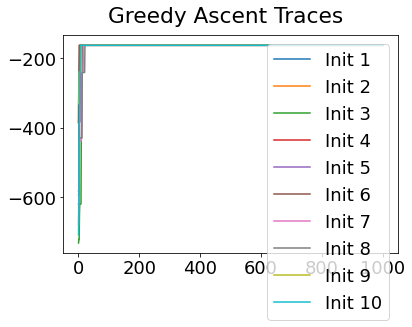

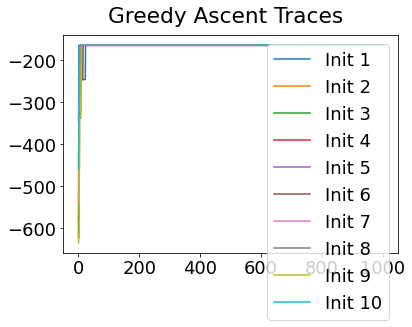

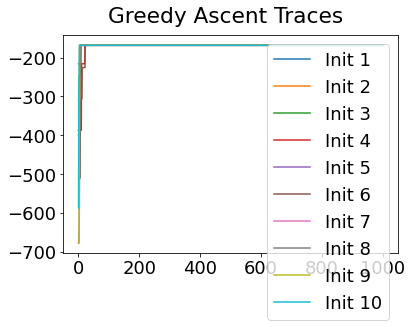

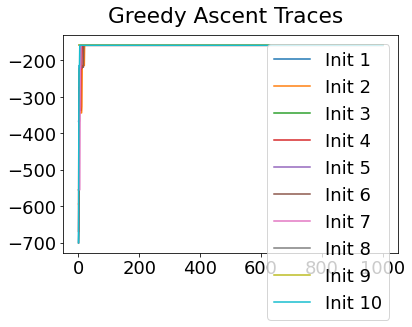

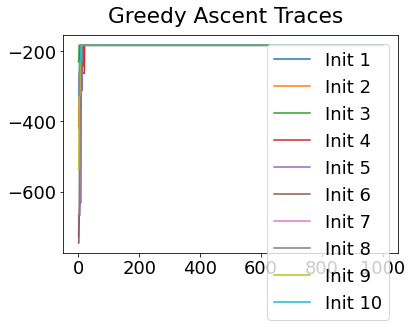

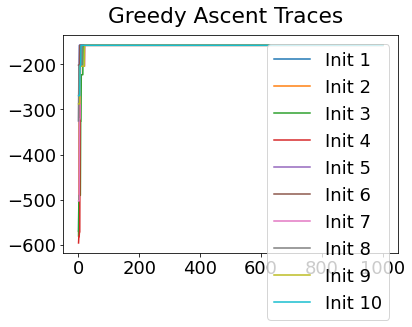

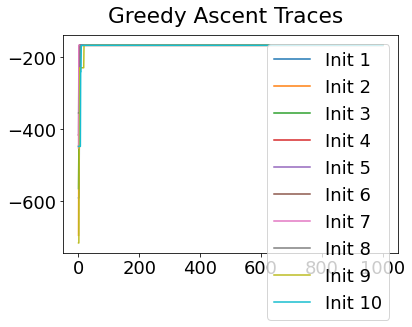

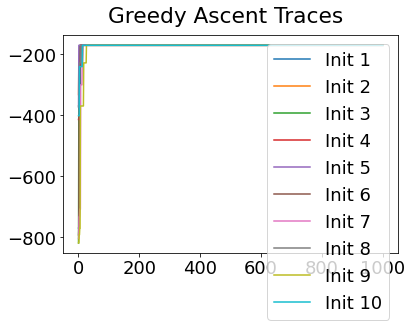

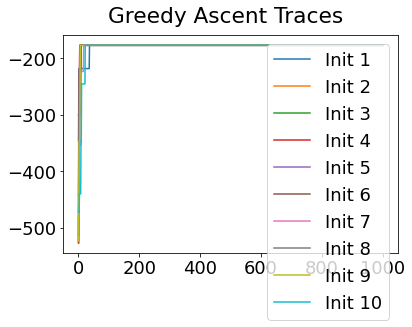

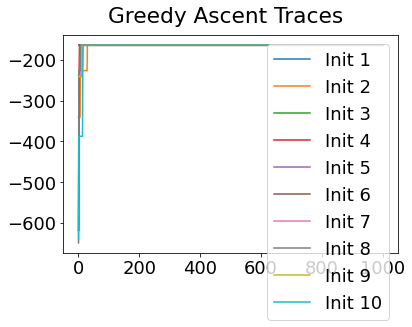

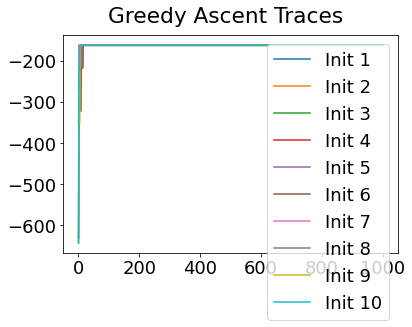

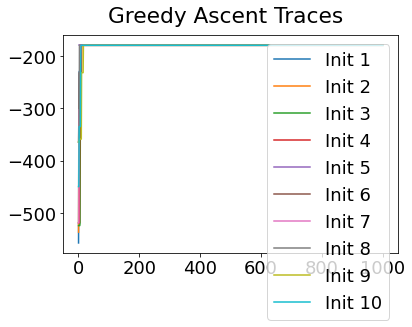

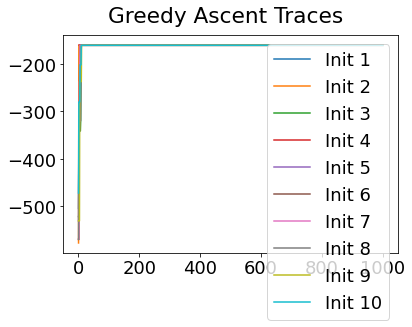

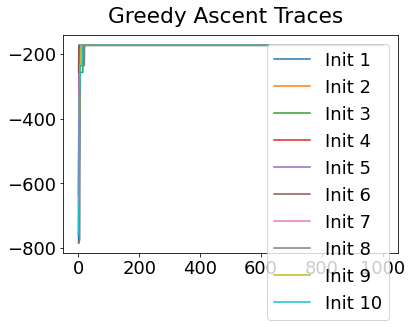

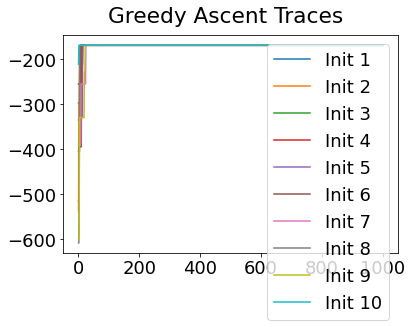

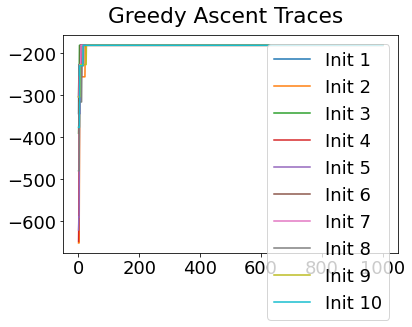

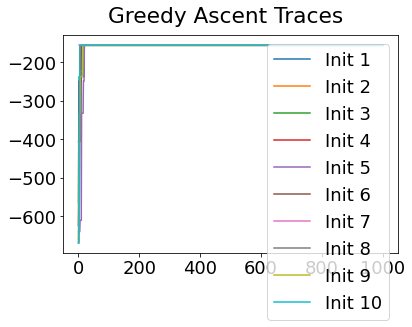

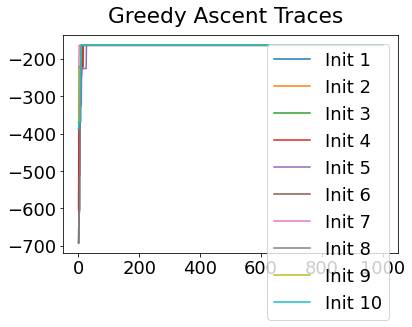

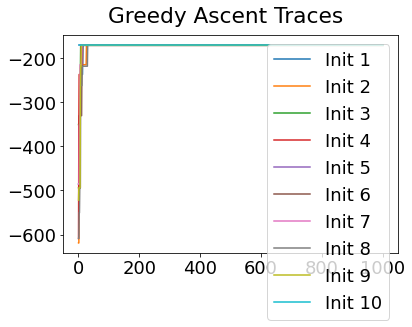

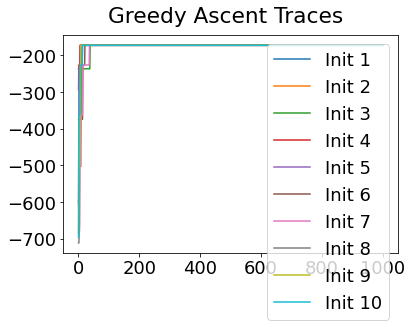

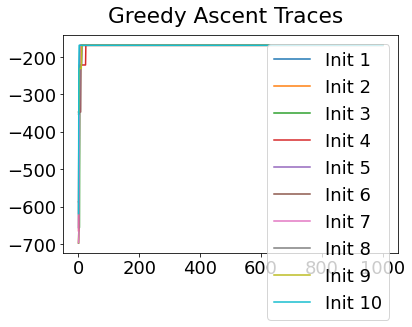

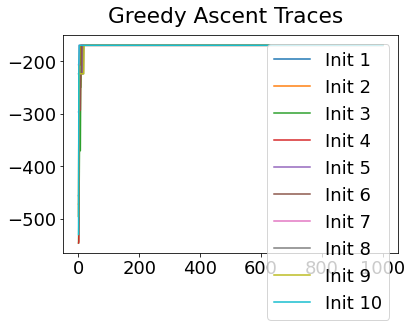

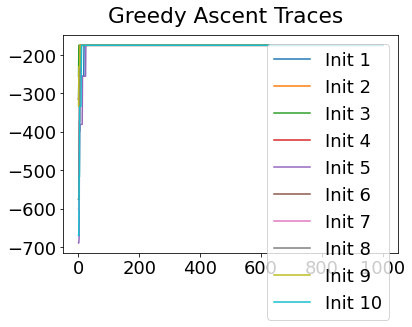

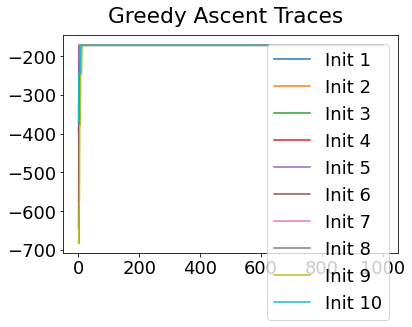

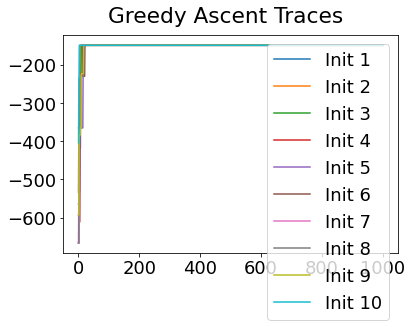

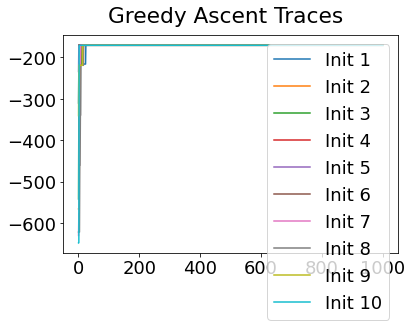

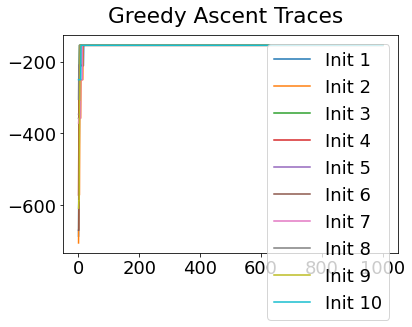

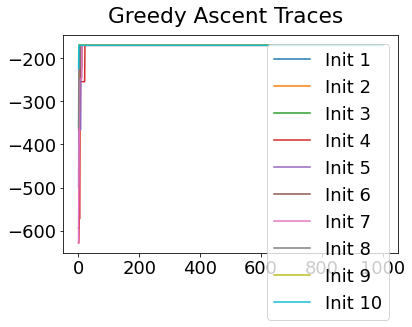

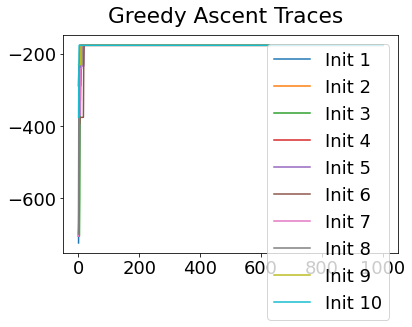

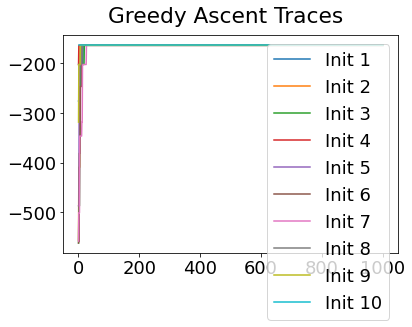

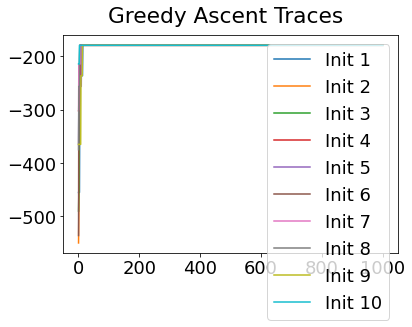

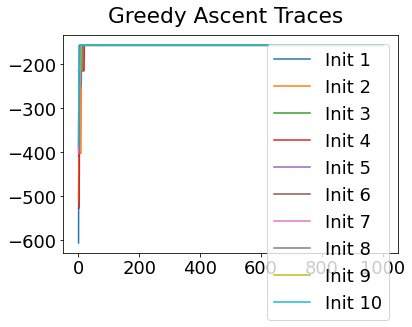

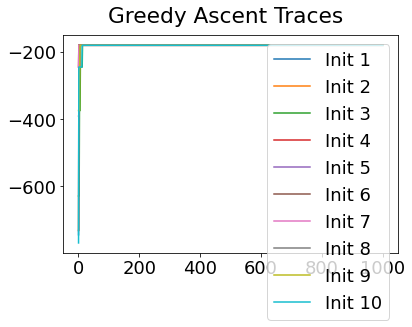

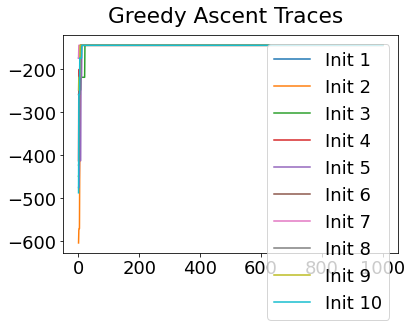

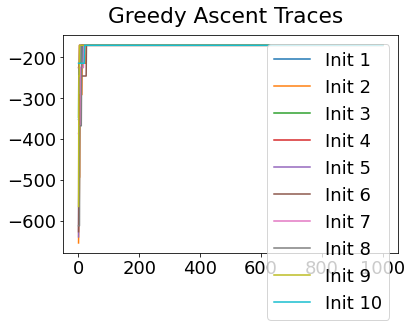

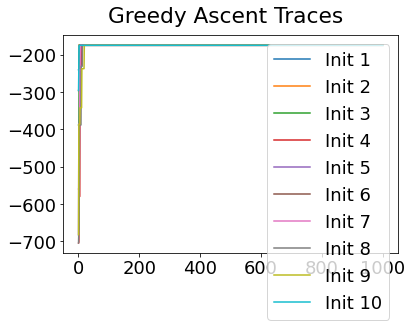

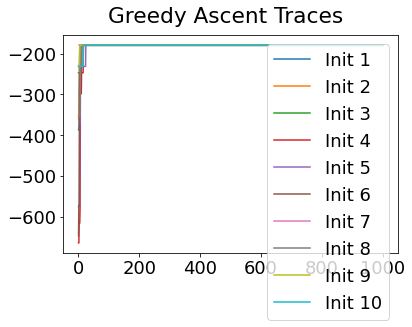

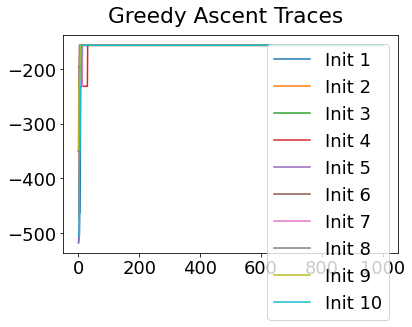

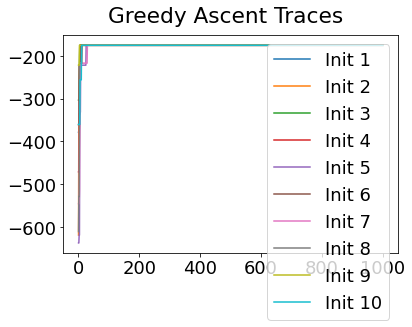

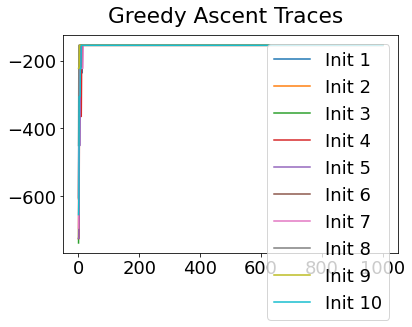

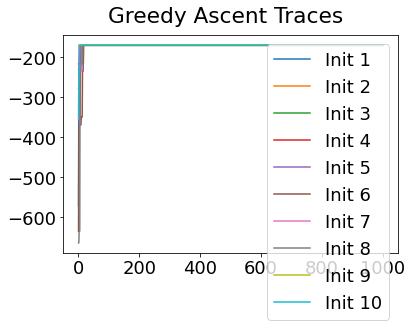

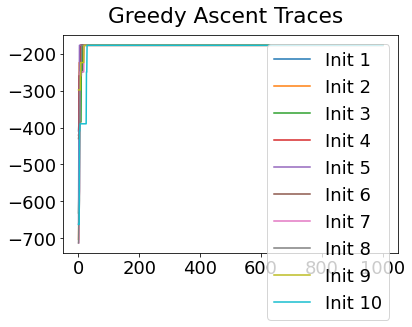

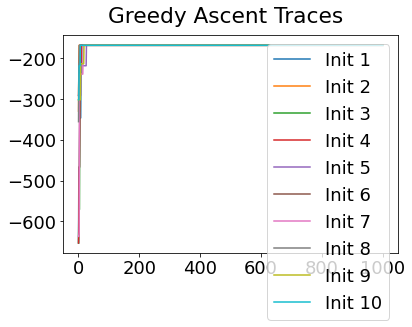

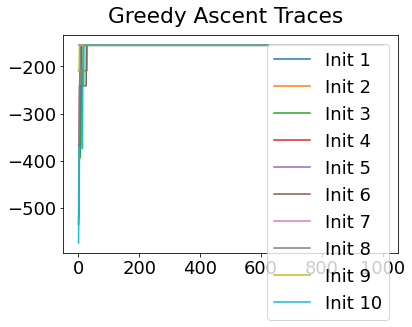

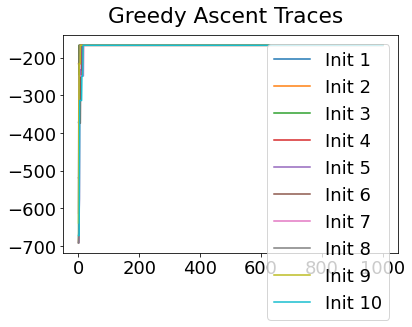

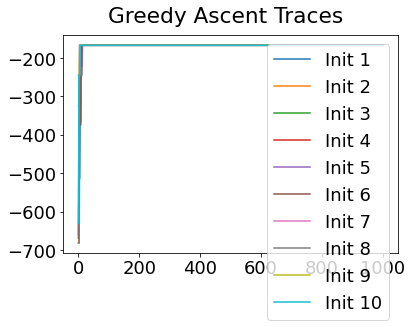

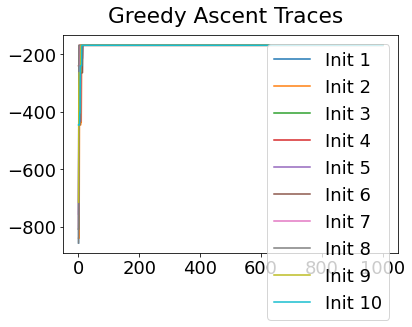

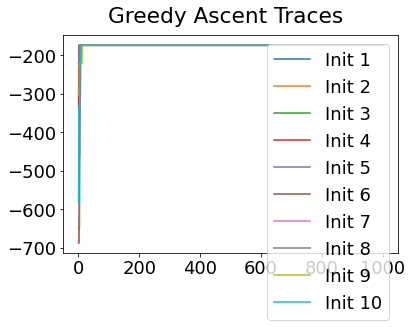

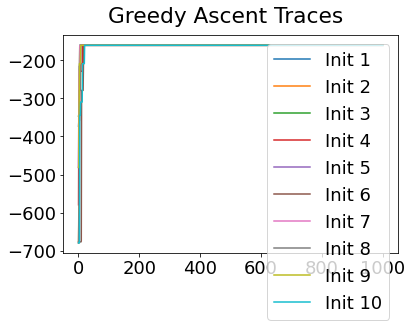

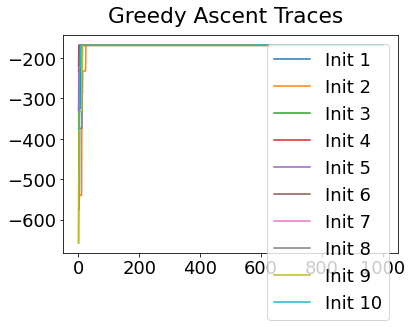

In [73]:
#* RCV1: Repeated, stratified 5-fold CV - uses ML stage as ground truth for test folds
k_folds = 5
n_repeats = 10

repeated_cvfolds = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=n_repeats) #, random_state=36851234)
if 'ebm_results' in locals():
    check = True
else:
    check = False


if check:
    if "mixtures_rcv" in ebm_results:
        kde_mixtures_rcv = ebm_results["mixtures_rcv"]
        mcmc_samples_rcv = ebm_results["mcmc_samples_rcv"]
        seqs_rcv = ebm_results["sequences_rcv"]
        staging_errors_rcv = ebm_results["staging_errors_rcv"]
        runit = False
    else:
        runit = True
else:
    runit = True

if runit:
    kde_mixtures_rcv, mcmc_samples_rcv, seqs_rcv, staging_errors_rcv = ebm_2_repeatedcv(
        x=X,
        y=y,
        events=e,
        rcv_folds=repeated_cvfolds,
        implement_fixed_controls=True,
        patholog_dirn_array=e_disease_direction,
        model_stage=stages_long
    )
    #* Save
    ebm_results["mixtures_rcv"] = kde_mixtures_rcv
    ebm_results["mcmc_samples_rcv"] = mcmc_samples_rcv
    ebm_results["sequences_rcv"] = seqs_rcv
    ebm_results["staging_errors_rcv"] = staging_errors_rcv
    # pickle_file = open(pickle_path,'wb')
    # pickle_output = pickle.dump(ebm_results, pickle_file)
    # pickle_file.close()

In [74]:
# Yet another convenience function
def extract_pvd(ml_order,samples):
    if type(ml_order) is list:
        #* List of PVDs from cross-validation/bootstrapping
        n_ = len(ml_order[0])
        pvd = np.zeros((n_,n_))
        #all_orders = np.array(ml_order)
        if type(samples[0]) is list:
            #* 10-fold CV returns MCMC samples for each fold separately in a list - concatenate them here
            all_samples = list(itertools.chain.from_iterable(samples))
        else:
            #* Bootstrapping returns MCMC samples pre-concatenated
            all_samples = samples
        all_orders = np.array([x.ordering for x in all_samples])
        for i in range(n_):
            pvd[i, :] = np.sum(all_orders == ml_order[0][i], axis=0)
        #pvd_cv, cv_rank = reorder_PVD_average_ranking(PVD=pvd)
        pvd, rank = reorder_PVD(pvd)
        seq = [ml_order[0][i] for i in rank]
    else:
        #* Single PVD (ML results)
        n_ = len(ml_order)
        pvd = np.zeros((n_,n_))
        samples_ = np.array([x.ordering for x in samples])
        seq = ml_order
        for i in range(n_):
            pvd[i, :] = np.sum(samples_ == seq[i], axis=0)
    return pvd, seq

Text(0.5, 0, 'Sequence')

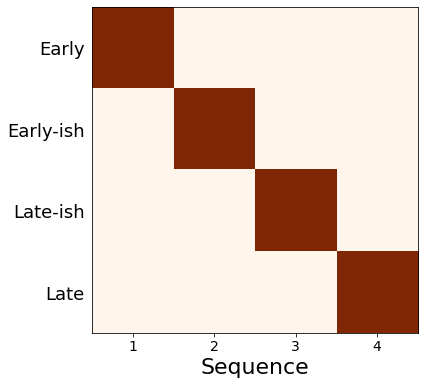

In [75]:
#* Plot EBM (PVD)
pvd_rcv, seq_rcv = extract_pvd(ml_order=seqs_rcv,samples=mcmc_samples_rcv)
reorder_rcv = np.argsort(seq_rcv)
pvd_rcv_ = pvd_rcv[:][reorder_rcv]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = e_labels
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_rcv]
ax.imshow(pvd_rcv_[:][seq_rcv], interpolation='nearest', cmap='Oranges')
# ax.set_title('Cross-Validation',fontsize=24)

n_biomarkers = pvd_rcv.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Sequence', fontsize=22)

If running on real data, you might consider staging your participant data using the cross-validated model (above uses the maximum-likleihood model which can be overconfident). Then you might re-run the CV.